In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Stratified k-fold cross-validation
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Support vector machine
from sklearn.svm import SVC

# K Neighbors Classifier
from sklearn.neighbors import KNeighborsClassifier as kNN

# GridSearch
from sklearn.model_selection import GridSearchCV

# sem
from scipy.stats import sem

# 指標を計算するため
from sklearn.metrics import accuracy_score, cohen_kappa_score, make_scorer, f1_score, recall_score, make_scorer, recall_score, auc, plot_roc_curve, confusion_matrix

# 特徴量重要度の計算 → Permutation imporatance
from sklearn.inspection import permutation_importance

# seaborn
import seaborn as sns
sns.set()

In [2]:
# データの読み込み
df=pd.read_csv('Table_Tch_all_data.csv')

#X yの設定
#Xの.dropで行or列を削除、axis=1で行を削除と指定。削除する行の指定は'group'で行う。
x=df.drop('group',axis=1) 

#yはdf内からgroupのみを取り出す。
y=df.group

In [3]:
# 標準化
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()

# 訓練用のデータを標準化
X = stdsc.fit_transform(x)

# label設定
label = df.columns[1:]

In [4]:
#層化k分割交差検証　n_splits=10のため 1/10 * 10回での検討
fold_num = 10
fold_seed = 26

skf = StratifiedKFold(n_splits=fold_num, shuffle=True, random_state=fold_seed)

cv = skf

In [5]:
%%time

# モデル選択
model = kNN()

# パラメーター設定
param_grid = {"n_neighbors": np.arange(1, 11)}

# パラメータチューニングをグリッドサーチ
gs = GridSearchCV(estimator = model,
                           param_grid = param_grid,
                           scoring = 'accuracy',
                           cv = cv,
                           return_train_score = True,
                           n_jobs = -1)

gs.fit(X, y)

CPU times: user 156 ms, sys: 68.6 ms, total: 224 ms
Wall time: 1.77 s


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=26, shuffle=True),
             estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])},
             return_train_score=True, scoring='accuracy')

In [6]:
print("best_params", gs.best_params_)

print("best_score", gs.best_score_)

best_params {'n_neighbors': 1}
best_score 0.7984848484848485


In [7]:
# Permutation importance

# 各foldで何回試行するか
iteration_num = 10
    
#  stratified cross validation
for i, (train, test) in enumerate(cv.split(X, y)):
    
    clf = kNN(n_neighbors=gs.best_params_['n_neighbors'])
    
    # 初回のみnumpy配列作成のため条件分岐
    if i == 0:
        print(f"========= fold:{i+1} =========")
        
        clf.fit(X[train], y[train])
    
        result = permutation_importance(clf, X[test], y[test], n_repeats=iteration_num, random_state=0)

        imp_list = np.array(result.importances)
    
        #print(imp_list)
    
    # 2回目以降は作成した配列に結合する
    else:
        print(f"========= fold:{i+1} =========")
        
        clf.fit(X[train], y[train])
    
        result = permutation_importance(clf, X[test], y[test], n_repeats=iteration_num, random_state=0)

        importance = np.array(result.importances)
    
        imp_list = np.concatenate((imp_list, importance), axis = 1) 
    
        #print(imp_list)

========= fold:1 =========
========= fold:2 =========
========= fold:3 =========
========= fold:4 =========
========= fold:5 =========
========= fold:6 =========
========= fold:7 =========
========= fold:8 =========
========= fold:9 =========
========= fold:10 =========


In [8]:
# resultで出力されたから特徴量ごとの平均と標準偏差を算出
imp_mean = np.mean(imp_list, axis=1)
imp_std=np.std(imp_list, axis=1)

#print("importance_mean", imp_mean)
#print("importance_standard_deviation", imp_std)

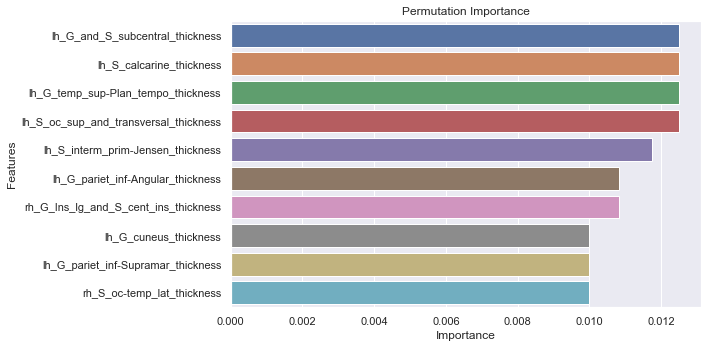

In [9]:
## Importanceの可視化

#  縦軸を特徴量、横軸をImportance_meanとしたDataframeを作成
df_importance = pd.DataFrame(zip(label, imp_mean), columns=["Features","Importance"])

# Importance_meanの順に並べ替え、上位10件のみを抽出する
df_importance = df_importance.sort_values("Importance", ascending=False).head(10)

# Figureの作成
plt.figure(figsize=(10,5))

sns.barplot(x="Importance", y="Features", data=df_importance, ci=95)
plt.title("Permutation Importance")
plt.tight_layout()

In [10]:
# Cross validationでのAccuracy確認
scores = cross_val_score(clf, X, y, cv=skf)

# 各分割におけるスコア
#print('Cross-Validation scores: {}'.format(scores))

# スコアの平均値
print('Average score: {}'.format(np.mean(scores)))

Average score: 0.7984848484848485


accuracy: [0.91666667 0.83333333 0.66666667 0.91666667 0.66666667 1.
 0.83333333 0.66666667 0.63636364 0.63636364]
mean_accuracy( 10 ): 0.7772727272727273
iteration_accuracy: [0.7772727272727273]
accuracy: [0.91666667 0.83333333 0.66666667 0.91666667 0.66666667 1.
 0.83333333 0.66666667 0.63636364 0.63636364]
mean_accuracy( 9 ): 0.7772727272727273
iteration_accuracy: [0.7772727272727273, 0.7772727272727273]
accuracy: [0.91666667 0.83333333 0.66666667 0.91666667 0.66666667 1.
 0.83333333 0.66666667 0.63636364 0.63636364]
mean_accuracy( 8 ): 0.7772727272727273
iteration_accuracy: [0.7772727272727273, 0.7772727272727273, 0.7772727272727273]
accuracy: [0.91666667 0.83333333 0.66666667 0.91666667 0.66666667 1.
 0.83333333 0.66666667 0.63636364 0.63636364]
mean_accuracy( 7 ): 0.7772727272727273
iteration_accuracy: [0.7772727272727273, 0.7772727272727273, 0.7772727272727273, 0.7772727272727273]
accuracy: [0.91666667 0.83333333 0.66666667 0.91666667 0.66666667 1.
 0.83333333 0.66666667 0.63636

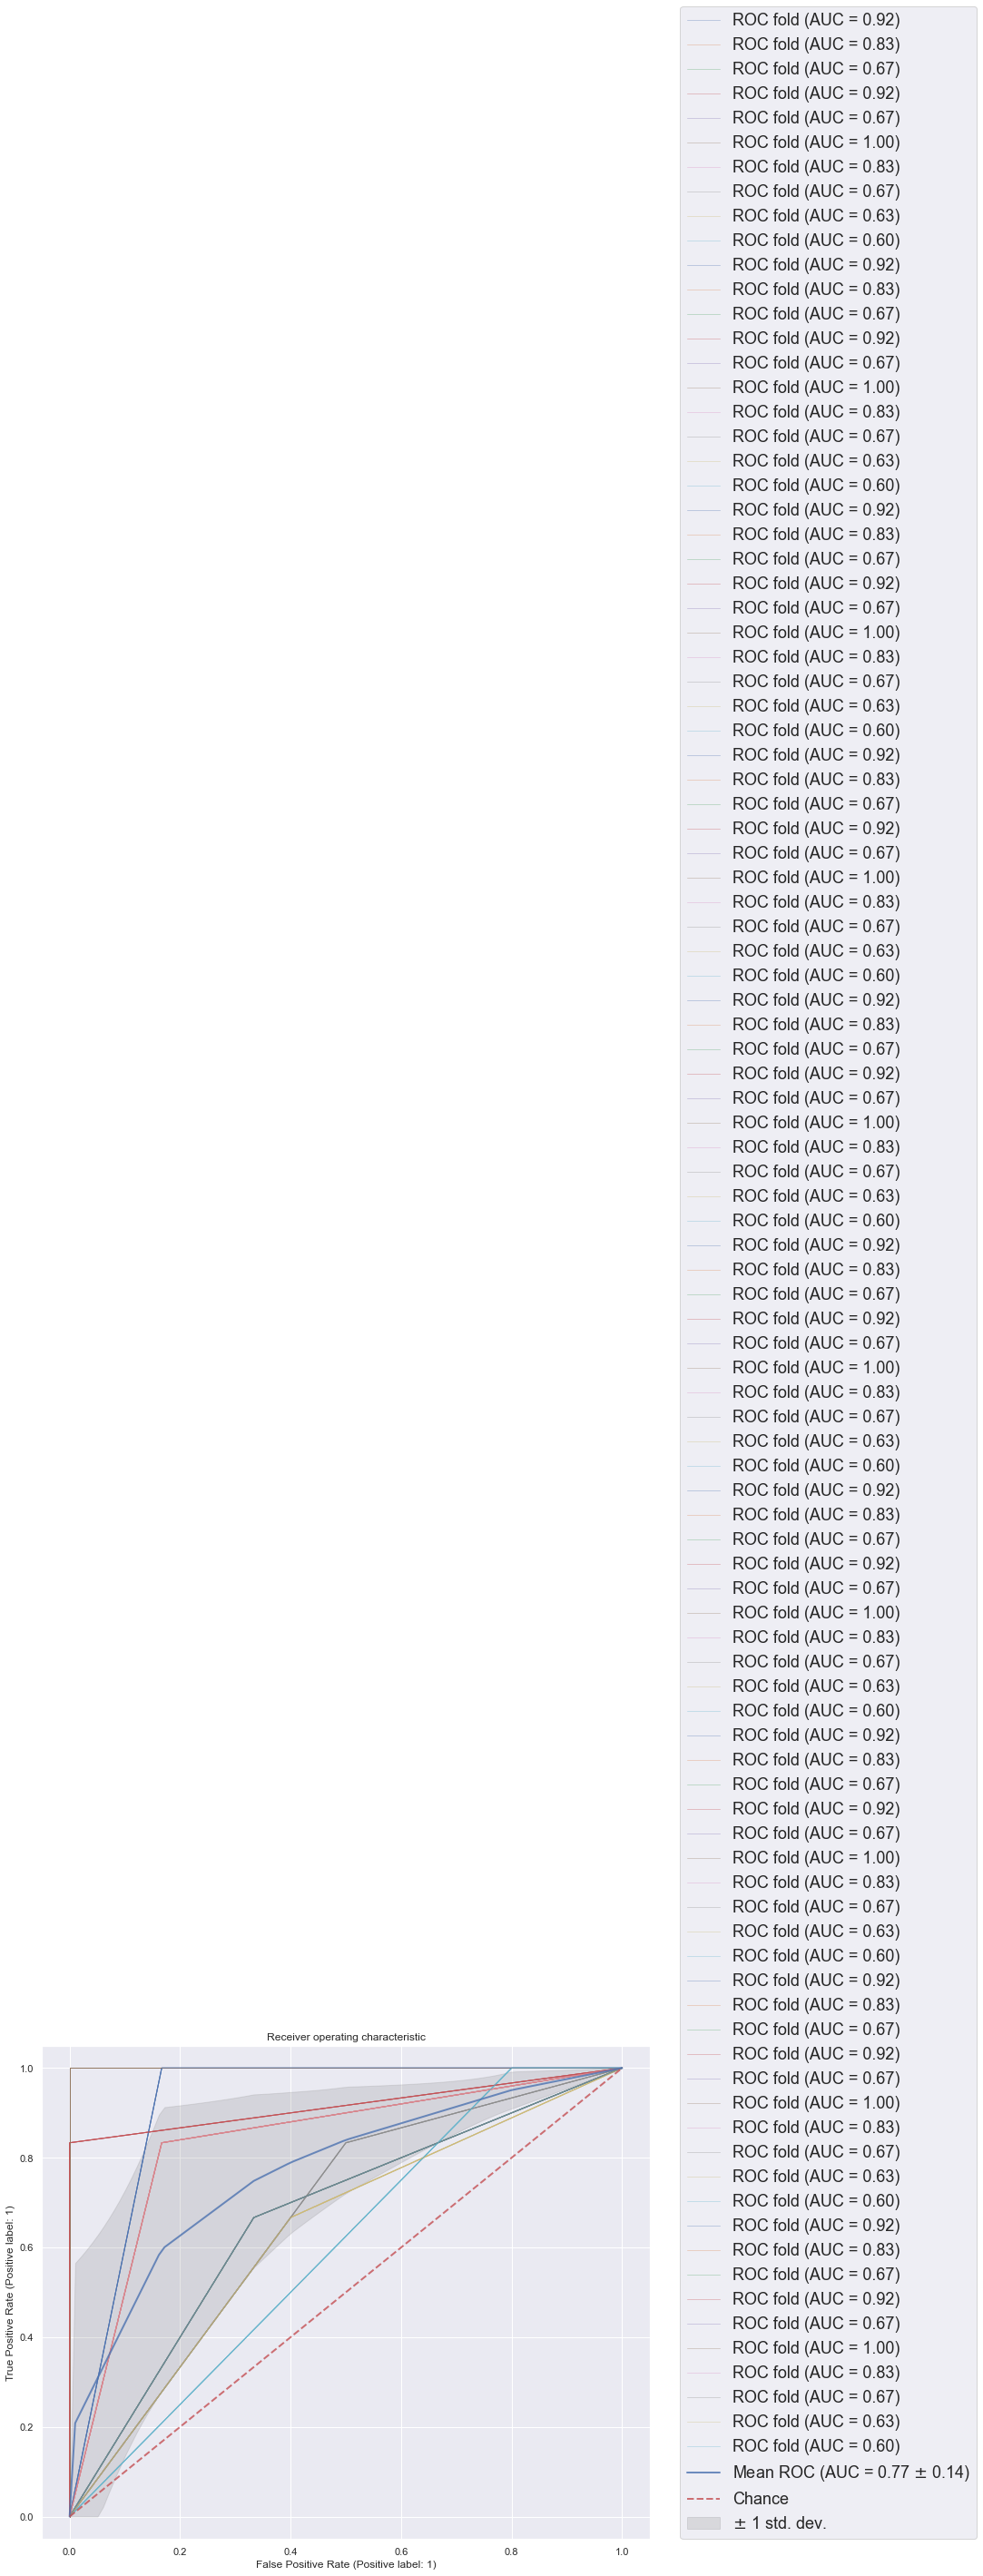

In [11]:
# Confusion matrix
tn = []
fp = []
fn = []
tp = []
tprs = []
aucs = []

mean_fpr = np.linspace(0, 1, 100)
fig, ax = plt.subplots(figsize=(12,10))

mean_accuracy = []
mean_sensitivity = []
mean_specificity = []

iteration_tprs = []
iteration_accuracy = []
iteration_sensitivity = []
iteration_specificity = []

# iterationを繰り返し数として設定

iteration = 10

cv_iteration = StratifiedKFold(n_splits=fold_num, shuffle=True, random_state=iteration)

while iteration > 0:
    
    for i, (train, test) in enumerate(cv_iteration.split(X, y)):
        
        clf.fit(X[train], y[train])
        
        # Confusion matrix
        y_pred = clf.predict(X[test])
        y_true = y[test]
        
        confmat = confusion_matrix(y_true, y_pred)
        tn.append(confusion_matrix(y_true, y_pred)[0][0])
        fp.append(confusion_matrix(y_true, y_pred)[0][1])
        fn.append(confusion_matrix(y_true, y_pred)[1][0])
        tp.append(confusion_matrix(y_true, y_pred)[1][1])
        
        accuracy = ((np.array(tp)+np.array(tn))/(np.array(tp)+np.array(fp)+np.array(fn)+np.array(tn)))
        sensitivity = (np.array(tp)/(np.array(tp)+np.array(fn)))
        specificity = (np.array(tn)/(np.array(tn)+np.array(fp)))
        
        # ROC curve
        viz = plot_roc_curve(clf, X[test], y[test], name='ROC fold'.format(i), alpha=0.3, lw=1, ax=ax)
        
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)
        
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)
        std_tpr = np.std(tprs, axis=0)
    
    # 10-fold後のaccuracy (10試行のaccuracy)
    print('accuracy:', accuracy)
    
    # 10-fold cross validationを1 iteration 試行した結果の各種指標。(=通常のCV)
    mean_accuracy = accuracy.mean()
    mean_sensitivity = sensitivity.mean()
    mean_specificity = specificity.mean()
        
    print ('mean_accuracy(', iteration, '):', mean_accuracy)
        
    #epoch_accuracyにepochごとの10-fold CV：mean_accuracyを追加。
    iteration_accuracy.append(mean_accuracy)
    
    print('iteration_accuracy:', iteration_accuracy)
    
    #1試行終了したのでConfusion matrixをクリアする。
    tn = np.delete(tn, 0, axis = 0)
    fp = np.delete(fp, 0, axis = 0)
    fn = np.delete(fn, 0, axis = 0)
    tp = np.delete(tp, 0, axis = 0)

    tn = []
    fp = []
    fn = []
    tp = []

    iteration = iteration -1
    
# while構文を抜けた(=iterationを規定回数終了)後の処理
# iteration回数繰り返したCVの平均を算出
    
mean_iteration_accuracy = np.mean(iteration_accuracy)
print('mean_iteration_accuracy:', mean_iteration_accuracy)

# ROC curve描画

ax.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=2, alpha=.8)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.2, label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic")
ax.legend(loc="lower right")

plt.legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0, fontsize=18)

plt.show()